> 로지스틱(2)-- 로지스틱 네트워크설계 및 학습, 손실함수의 비교: BCE loss의 위대함

# 강의영상

<https://youtube.com/playlist?list=PLQqh36zP38-xTS1PLLmvw8ECtkv6M1RTN>

# Imports

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Logistic regression intro

## motive 

`-` 현실에서 이런 경우가 많음 

- $x$가 커질수록 (혹은 작아질수록) 성공확률이 증가함. 

`-` (X,y)는 어떤모양? 

In [13]:
_df = pd.DataFrame({'x':range(-6,7),'y':[0,0,0,0,0,0,1,0,1,1,1,1,1]})
_df 

x  y
0  -6  0
1  -5  0
2  -4  0
3  -3  0
4  -2  0
5  -1  0
6   0  1
7   1  0
8   2  1
9   3  1
10  4  1
11  5  1
12  6  1

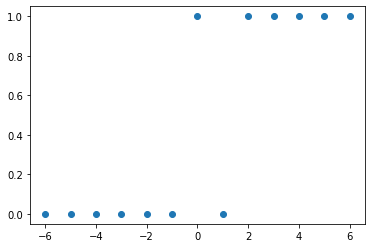

In [14]:
plt.plot(_df.x,_df.y,'o')

`-` (예비학습) 시그모이드라는 함수가 있음 

In [22]:
_x = torch.linspace(-6,6,100)
def f(x):
    return torch.exp(x)/(1+torch.exp(x))

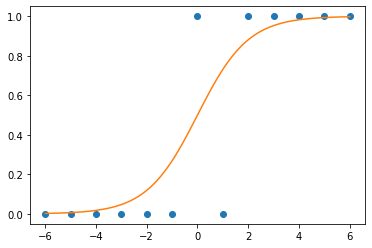

In [23]:
plt.plot(_df.x,_df.y,'o')
plt.plot(_x,f(_x))

### model

`-` $x$가 커질수록 $y=1$이 잘나오는 모형은 아래와 같이 설계할 수 있음 <--- 외우세요!!!

- $y_i \sim Ber(\pi_i),\quad$ where $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$

- $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$ 

- $loss= - \sum_{i=1}^{n} \big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$ <--- 외우세요!!

### toy example

`-` 예제시작 

In [24]:
x=torch.linspace(-1,1,2000).reshape(2000,1)
w0= -1 
w1= 5 
u = w0+x*w1 
v = torch.exp(u)/(1+torch.exp(u)) # v=πi, 즉 확률을 의미함
y = torch.bernoulli(v) 

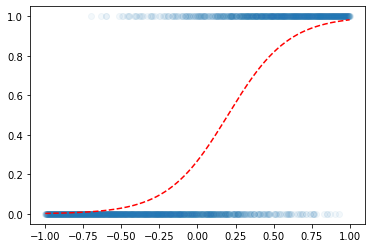

In [25]:
plt.scatter(x,y,alpha=0.05)
plt.plot(x,v,'--r')

- 우리의 목적: $x$가 들어가면 빨간선 $\hat{y}$의 값을 만들어주는 mapping을 학습해보자. 

---

## net 설계 

`-` 최초곡선 

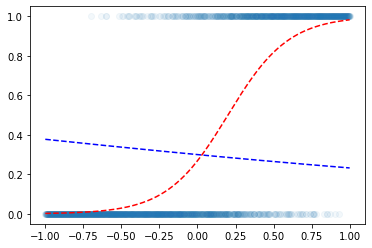

In [26]:
plt.scatter(x,y,alpha=0.05)
plt.plot(x,v,'--r')
w0hat = -0.8470
w1hat = -0.3467 
plt.plot(x,f(x*w1hat+w0hat),'--b')

`-` f 대신에 torch.nn.Sigmoid() 사용해서 함수만들어도 무방 

In [27]:
a1 = torch.nn.Sigmoid()

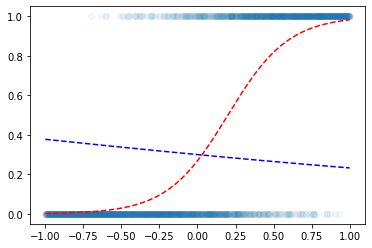

In [28]:
plt.scatter(x,y,alpha=0.05)
plt.plot(x,v,'--r')
w0hat = -0.8470
w1hat = -0.3467 
plt.plot(x,a1(x*w1hat+w0hat),'--b')

`-` x*w1hat + w0hat 대신에 torch.nn.Linear() 로 써도 무방 

In [29]:
torch.manual_seed(43052) 
l1=torch.nn.Linear(in_features=1,out_features=1,bias=True) 

In [30]:
l1.weight

Parameter containing:
tensor([[-0.3467]], requires_grad=True)

In [31]:
l1.bias

Parameter containing:
tensor([-0.8470], requires_grad=True)

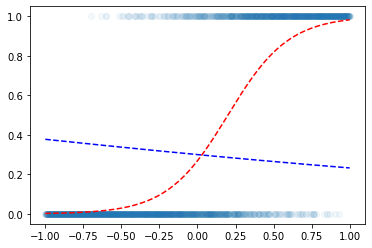

In [32]:
plt.scatter(x,y,alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,a1(l1(x)).data,'--b')

`-` 지금 $x \overset{l1}{\to} u \overset{a1}{\to} v = \hat{y}$ 구조임 

`-` l1,a1 을 sequential 하게 (직렬로) 엮어서 $ x \overset{net}{\to} \hat{y}$ 로 만들수 없을까? 

In [33]:
net = torch.nn.Sequential(l1,a1) 

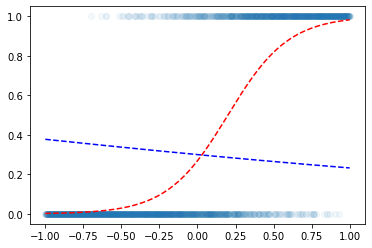

In [34]:
plt.scatter(x,y,alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,net(x).data,'--b')

## 학습

`-` 이제 옵티마이저 설계하고 학습하자. 

In [36]:
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

`-` step1~4 

(1000번 학습)

In [37]:
for epoc in range(1000): 
    ## 1 
    yhat= net(x) 
    ## 2 
    loss= torch.mean((y-yhat)**2) ## loss가 사실 이러면 안됩니다.. ㅠㅠ 
    ## 3 
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

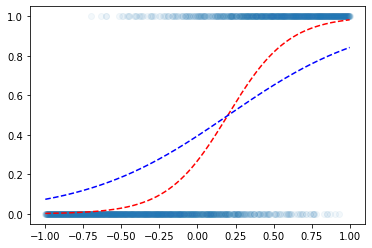

In [38]:
plt.scatter(x,y,alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,net(x).data,'--b')

(5000번 추가학습)

In [39]:
for epoc in range(5000): 
    ## 1 
    yhat= net(x) 
    ## 2 
    loss= torch.mean((y-yhat)**2) ## 사실 이러면 안됩니다.. ㅠㅠ 
    ## 3 
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

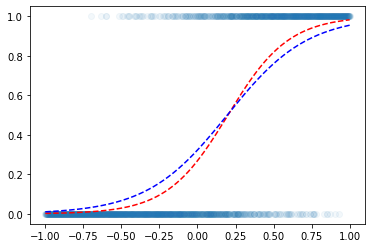

In [40]:
plt.scatter(x,y,alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,net(x).data,'--b')

.. 성공? 

# BCE loss의 위대함

## MSE loss 와 BCE loss 의 비교

`-` loss_fn1, loss_fn2 

In [189]:
def loss_fn1(y,yhat): 
    return torch.mean((y-yhat)**2)

In [190]:
def loss_fn2(y,yhat):
    return -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))

`-` loss_fn1(MSE), SGD, lr=0.05

In [191]:
torch.manual_seed(43052) 
net = torch.nn.Sequential(torch.nn.Linear(1,1),torch.nn.Sigmoid()) 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 
for epoc in range(1000): 
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn1(y,yhat)
    ## step3
    loss.backward() 
    ## step4 
    optimizr.step()
    optimizr.zero_grad() 

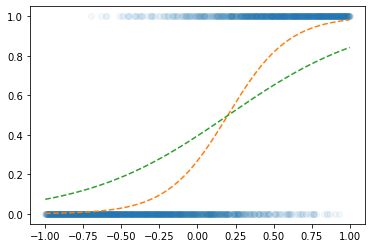

In [192]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,v,'--')
plt.plot(x,net(x).data,'--')

`-` loss_fn2(BCE), SGD, lr=0.05

In [193]:
torch.manual_seed(43052) 
net = torch.nn.Sequential(torch.nn.Linear(1,1),torch.nn.Sigmoid()) 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 
for epoc in range(1000): 
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn2(y,yhat)
    ## step3
    loss.backward() 
    ## step4 
    optimizr.step()
    optimizr.zero_grad() 

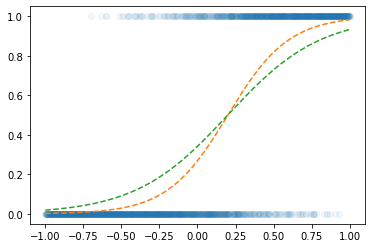

In [194]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,v,'--')
plt.plot(x,net(x).data,'--')

!! loss_fn2 로 하니까 더 잘맞는다? 

?? 왜?????

`-` 손실함수의 모양이 다르다.. 

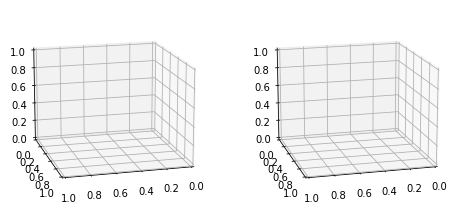

In [310]:
fig = plt.figure()
ax1=fig.add_subplot(1,2,1,projection='3d')
ax2=fig.add_subplot(1,2,2,projection='3d')
ax1.elev=15;ax2.elev=15;ax1.azim=75;ax2.azim=75
fig.set_figheight(8)
fig.set_figwidth(8)

In [311]:
def plot_loss(loss_fn,ax):
    w0hat,w1hat =torch.meshgrid(torch.arange(-10,3,0.15),torch.arange(-1,10,0.15),indexing='ij')
    w0hat = w0hat.reshape(-1)
    w1hat = w1hat.reshape(-1)
    def l(w0hat,w1hat):
        yhat = torch.exp(w0hat+w1hat*x)/(1+torch.exp(w0hat+w1hat*x))
        return loss_fn(y,yhat) 
    loss = list(map(l,w0hat,w1hat))
    ax.scatter(w0hat,w1hat,loss,s=0.1,alpha=0.2) 
    ax.scatter(-1,5,l(-1,5),s=200,marker='*') # 실제로 -1,5에서 최소값을 가지는건 아님.. 

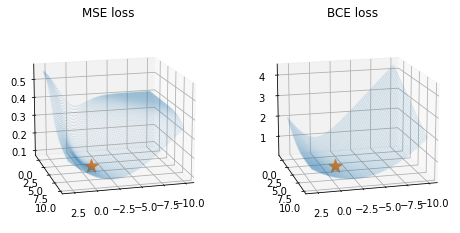

In [312]:
plot_loss(loss_fn1,ax1)
plot_loss(loss_fn2,ax2)
ax1.set_title('MSE loss')
ax2.set_title('BCE loss')
fig

- 왼쪽 그림은 손실함수가 convex 하지 않다.
- 오른쪽 그림은 손실함수가 convex 하다. 

## 시각화를 위한 준비함수들 

**준비1: for문 대신 돌려주고 epoch마다 필요한 정보를 기록하는 함수를 만들자!**

In [470]:
def learn_and_record(net, loss_fn, optimizr):
    yhat_history = [] 
    loss_history = []
    what_history = [] 

    for epoc in range(1000): 
        ## step1 
        yhat = net(x)
        ## step2 
        loss = loss_fn(y,yhat)
        ## step3
        loss.backward() 
        ## step4 
        optimizr.step()
        optimizr.zero_grad() 

        ## record 
        if epoc % 20 ==0: 
            yhat_history.append(yhat.reshape(-1).data.tolist())
            loss_history.append(loss.item())
            what_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
    return yhat_history, loss_history, what_history

**준비2: 애니메이션을 만들어주는 함수를 만들자!**

In [471]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

In [472]:
def show_lrpr2(net,loss_fn,optimizr,suptitle=''):
    yhat_history,loss_history,what_history = learn_and_record(net,loss_fn,optimizr)
    
    fig = plt.figure(figsize=(7,2.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax1.set_xticks([]);ax1.set_yticks([])
    ax2.set_xticks([]);ax2.set_yticks([]);ax2.set_zticks([])
    ax2.elev = 15; ax2.azim = 75

    ## ax1: 왼쪽그림 
    ax1.plot(x,v,'--')
    ax1.scatter(x,y,alpha=0.05)
    line, = ax1.plot(x,yhat_history[0],'--') 
    plot_loss(loss_fn,ax2)
    fig.suptitle(suptitle)
    fig.tight_layout()

    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        ax2.scatter(np.array(what_history)[epoc,0],np.array(what_history)[epoc,1],loss_history[epoc],color='grey')
        return line

    ani = animation.FuncAnimation(fig, animate, frames=30)
    plt.close()
    return ani

## 시각화1: MSE loss, SGD, 좋은초기값

In [443]:
l1 = torch.nn.Linear(1,1)
a1 = torch.nn.Sigmoid()
net = torch.nn.Sequential(l1,a1) 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [444]:
l1.bias.data = torch.tensor([-3.0])
l1.weight.data = torch.tensor([[-1.0]])

In [445]:
show_lrpr2(net,loss_fn1,optimizr,'MSEloss, SGD, good_init')

## 시각화2: BCE loss, SGD, 좋은초기값

In [448]:
l1 = torch.nn.Linear(1,1)
a1 = torch.nn.Sigmoid()
net = torch.nn.Sequential(l1,a1) 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [449]:
l1.bias.data = torch.tensor([-3.0])
l1.weight.data = torch.tensor([[-1.0]])

In [450]:
show_lrpr2(net,loss_fn2,optimizr)

## 시각화3: MSE loss, SGD, 나쁜초기값

In [451]:
l1 = torch.nn.Linear(1,1)
a1 = torch.nn.Sigmoid()
net = torch.nn.Sequential(l1,a1) 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [452]:
l1.bias.data = torch.tensor([-10.0])
l1.weight.data = torch.tensor([[-1.0]])

In [453]:
show_lrpr2(net,loss_fn1,optimizr)

## 시각화4: BCE loss, SGD, 나쁜초기값 (?)

In [454]:
l1 = torch.nn.Linear(1,1)
a1 = torch.nn.Sigmoid()
net = torch.nn.Sequential(l1,a1) 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [455]:
l1.bias.data = torch.tensor([-10.0])
l1.weight.data = torch.tensor([[-1.0]])

In [456]:
show_lrpr2(net,loss_fn2,optimizr)

# 숙제

`-` 시각화1~4에서 optimizer를 Adam으로 설정하고 돌려볼 것

(hint) 시각화1의 경우 아래와 같이 코드를 수정하면 된다. 

**시각화1: MSE loss, `ADAM`, 좋은초기값**

In [462]:
l1 = torch.nn.Linear(1,1)
a1 = torch.nn.Sigmoid()
net = torch.nn.Sequential(l1,a1) 
optimizr = torch.optim.Adam(net.parameters(),lr=0.05) 

In [463]:
l1.bias.data = torch.tensor([-3.0])
l1.weight.data = torch.tensor([[-1.0]])

In [464]:
show_lrpr2(net,loss_fn1,optimizr,'MSEloss, ADAM, good_init')